# Democracy Index Forecasting Notebook

### Environment Setup and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').disabled = True

df = pd.read_csv("democracy-index-eiu.csv")

df = df.rename(columns={
    "Entity": "country",
    "Code": "code",
    "Year": "year",
    "Democracy score": "score"
})

df["year"] = df["year"].astype(int)
df["score"] = df["score"].astype(float)

### Exploratory Data Analysis (EDA)
- #### Data Overview

In [2]:
display(df.head())
print("\nInfo:")
display(df.info())

,country,code,year,score
0,Afghanistan,AFG,2006,3.06
1,Afghanistan,AFG,2008,3.02
2,Afghanistan,AFG,2010,2.48
3,Afghanistan,AFG,2011,2.48
4,Afghanistan,AFG,2012,2.48



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  2838 non-null   object 
 1   code     2838 non-null   object 
 2   year     2838 non-null   int64  
 3   score    2838 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 88.8+ KB


None

- #### Dataset Coverage

In [3]:
print("\n=== Coverage ===")
print("Number of countries:", df.country.nunique())
print("Years covered:", df.year.min(), "→", df.year.max())

country_counts = df.groupby("country").size().sort_values()
print("\n=== Observations per Country (smallest shown first) ===")
display(country_counts.head(10))


=== Coverage ===
Number of countries: 167
Years covered: 2006 → 2024

=== Observations per Country (smallest shown first) ===


country
Australia          16
Afghanistan        17
Nepal              17
Netherlands        17
New Zealand        17
Nicaragua          17
Niger              17
Nigeria            17
North Korea        17
North Macedonia    17
dtype: int64

- #### Missing Values

In [4]:
print("=== Basic Missing Value Check ===")
display(df.isna().sum())

year_counts = df.groupby("year").size()

print("\n=== Counts Per Year (How many country entries each year) ===")
display(year_counts)

expected_years = list(range(df["year"].min(), df["year"].max() + 1))
actual_years = sorted(df["year"].unique())

missing_years = sorted(set(expected_years) - set(actual_years))

print("\n=== Missing Entire Years in Dataset ===")
if missing_years:
    print("Missing years:", missing_years)
else:
    print("No completely missing years.")

missing_by_country = (
    df.groupby("country")["score"]
      .apply(lambda x: x.isna().sum())
)

missing_by_country = missing_by_country[missing_by_country > 0]

print("\n=== Countries With Missing Scores ===")
if len(missing_by_country) > 0:
    display(missing_by_country.sort_values())
else:
    print("No missing country-level values.")

if "Australia" in missing_by_country.index:
    print("\n⚠️ Note: Australia is missing exactly one value (year 2009).")

START_YEAR = 2010
print(f"\n=== Filtering dataset to years >= {START_YEAR} ===")

df = df[df["year"] >= START_YEAR].reset_index(drop=True)

print(f"Data now includes years: {sorted(df['year'].unique())[:5]} … {sorted(df['year'].unique())[-5:]}")
print(f"Total rows after filtering: {len(df)}")

df.head()


=== Basic Missing Value Check ===


country    0
code       0
year       0
score      0
dtype: int64


=== Counts Per Year (How many country entries each year) ===


year
2006    166
2008    167
2010    167
2011    167
2012    167
2013    167
2014    167
2015    167
2016    167
2017    167
2018    167
2019    167
2020    167
2021    167
2022    167
2023    167
2024    167
dtype: int64


=== Missing Entire Years in Dataset ===
Missing years: [2007, 2009]

=== Countries With Missing Scores ===
No missing country-level values.

=== Filtering dataset to years >= 2010 ===
Data now includes years: [2010, 2011, 2012, 2013, 2014] … [2020, 2021, 2022, 2023, 2024]
Total rows after filtering: 2505


,country,code,year,score
0,Afghanistan,AFG,2010,2.48
1,Afghanistan,AFG,2011,2.48
2,Afghanistan,AFG,2012,2.48
3,Afghanistan,AFG,2013,2.48
4,Afghanistan,AFG,2014,2.77


- #### Global democracy trend over time

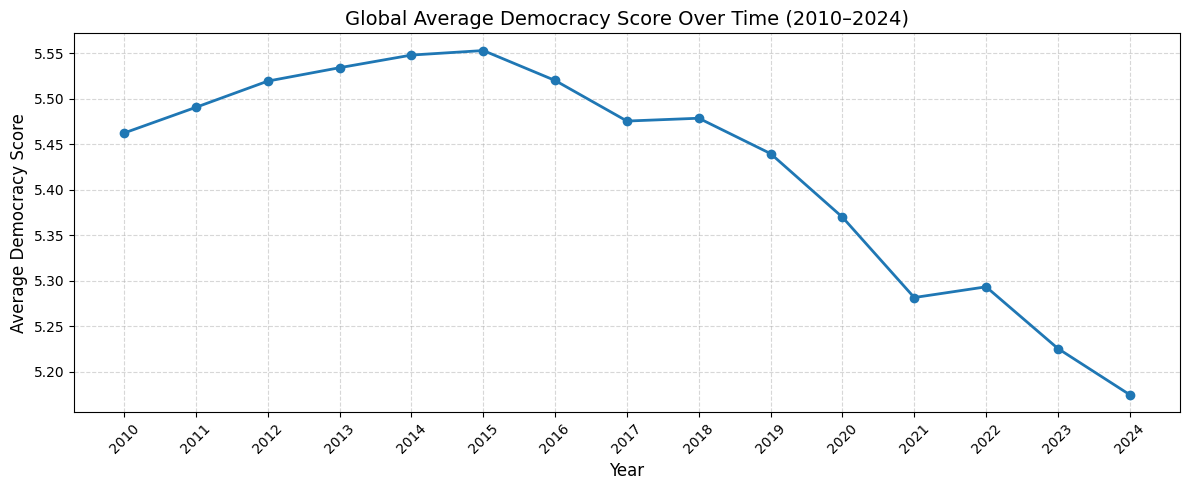

In [5]:
global_trend = (
    df.groupby("year")["score"]
      .mean()
      .reset_index()
      .sort_values("year")
)

plt.figure(figsize=(12, 5))
plt.plot(global_trend["year"], global_trend["score"], marker="o", linewidth=2)

plt.title("Global Average Democracy Score Over Time (2010–2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Democracy Score", fontsize=12)

plt.xticks(
    ticks=global_trend["year"],
    labels=global_trend["year"].astype(str),
    rotation=45
)

plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


### Data Preparation for Prophet

In [6]:
all_years = pd.Series(range(df.year.min(), df.year.max() + 1))


def prepare_country_df(df, country_name):
    temp = df[df.country == country_name].copy()

    full_df = pd.DataFrame({"year": all_years})

    merged = full_df.merge(temp, on="year", how="left")

    merged["ds"] = pd.to_datetime(merged["year"], format="%Y")

    merged["y"] = merged["score"]

    prophet_df = merged[["ds", "y"]].sort_values("ds").reset_index(drop=True)
    
    return prophet_df


### Prophet Forecasting Function

In [7]:
def forecast_country(df, country_name, periods=6):

    country_df = prepare_country_df(df, country_name)

    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.7
    )

    model.fit(country_df)

    future = model.make_future_dataframe(periods=periods, freq='YE')

    future["ds"] = future["ds"].dt.to_period("Y").dt.to_timestamp("Y")

    forecast = model.predict(future)

    forecast["yhat"] = forecast["yhat"].clip(0, 10)
    forecast["yhat_lower"] = forecast["yhat_lower"].clip(0, 10)
    forecast["yhat_upper"] = forecast["yhat_upper"].clip(0, 10)

    return forecast, model, country_df

In [8]:
# =============================================
# QUICK SANITY CHECK: sample countries
# =============================================

sample_countries = ["Afghanistan", "Zimbabwe", "Australia", "United States", "China"]

for country in sample_countries:
    country_df = df[df["country"] == country].sort_values("year")
    print(f"\n=== {country} ===")
    print(country_df[["year", "score"]])



=== Afghanistan ===
    year  score
0   2010   2.48
1   2011   2.48
2   2012   2.48
3   2013   2.48
4   2014   2.77
5   2015   2.77
6   2016   2.55
7   2017   2.55
8   2018   2.97
9   2019   2.85
10  2020   2.85
11  2021   0.32
12  2022   0.32
13  2023   0.26
14  2024   0.25

=== Zimbabwe ===
      year  score
2490  2010   2.64
2491  2011   2.68
2492  2012   2.67
2493  2013   2.67
2494  2014   2.78
2495  2015   3.05
2496  2016   3.05
2497  2017   3.16
2498  2018   3.16
2499  2019   3.16
2500  2020   3.16
2501  2021   2.92
2502  2022   2.92
2503  2023   3.04
2504  2024   2.98

=== Australia ===
     year  score
90   2010   9.22
91   2011   9.22
92   2012   9.22
93   2013   9.13
94   2014   9.01
95   2015   9.01
96   2016   9.01
97   2017   9.09
98   2018   9.09
99   2019   9.09
100  2020   8.96
101  2021   8.90
102  2022   8.71
103  2023   8.66
104  2024   8.85

=== United States ===
      year  score
2385  2010   8.18
2386  2011   8.11
2387  2012   8.11
2388  2013   8.11
2389  2014   

### Multi-Country Forecasting Loop (2025–2030)

In [9]:
all_forecasts = []

FORECAST_YEARS = 7   # 2025–2030

countries = df.country.unique()

print(f"Forecasting {len(countries)} countries...")

for country in countries:
    try:
        forecast, model, country_df = forecast_country(df, country, periods=FORECAST_YEARS)

        forecast["country"] = country

        future_rows = forecast[forecast["ds"].dt.year >= df.year.max() + 1]

        future_rows = future_rows[[
            "country",
            "ds",
            "yhat",
            "yhat_lower",
            "yhat_upper"
        ]]
        
        all_forecasts.append(future_rows)
    
    except Exception as e:
        print(f"⚠️ Error forecasting {country}: {e}")
        continue

final_forecast_df = pd.concat(all_forecasts, ignore_index=True)

print("\nForecasting completed!")
display(final_forecast_df.head())
display(final_forecast_df.tail())


Forecasting 167 countries...

Forecasting completed!


,country,ds,yhat,yhat_lower,yhat_upper
0,Afghanistan,2025-12-31,0.0,0.0,0.0
1,Afghanistan,2026-12-31,0.0,0.0,0.0
2,Afghanistan,2027-12-31,0.0,0.0,0.0
3,Afghanistan,2028-12-31,0.0,0.0,0.0
4,Afghanistan,2029-12-31,0.0,0.0,0.0


,country,ds,yhat,yhat_lower,yhat_upper
997,Zimbabwe,2026-12-31,3.092495,2.535254,3.653518
998,Zimbabwe,2027-12-31,3.120558,2.339333,3.943157
999,Zimbabwe,2028-12-31,3.148698,2.115685,4.166270
1000,Zimbabwe,2029-12-31,3.176762,1.864183,4.437764
1001,Zimbabwe,2030-12-31,3.204825,1.539260,4.753474


### Combine Historical + Forecast

In [10]:
historical_df = df.rename(columns={"year": "ds", "score": "y"})
historical_df["ds"] = pd.to_datetime(historical_df["ds"], format="%Y")

combined = pd.concat([
    historical_df[["country", "ds", "y"]].rename(columns={"y": "value"}),
    final_forecast_df.rename(columns={"yhat": "value"})[["country", "ds", "value"]]
], ignore_index=True)

### Regime Classification for Historical + Forecasted Scores

In [11]:
def classify_regime(score):

    if pd.isna(score):
        return None
    if score >= 8.01:
        return "Full Democracy"
    elif score >= 6.01:
        return "Flawed Democracy"
    elif score >= 4.01:
        return "Hybrid Regime"
    else:
        return "Authoritarian"

combined["regime"] = combined["value"].apply(classify_regime)

transition_df = combined[combined["ds"].dt.year >= df.year.max() + 1].copy()

latest_year = df.year.max()

latest_hist = (
    combined[combined["ds"].dt.year == latest_year]
    .groupby("country")["regime"]
    .first()
    .reset_index()
    .rename(columns={"regime": "regime_2024"})
)

forecast_target_year = latest_year + 6  # 2024 -> 2030
forecast_target = (
    combined[combined["ds"].dt.year == forecast_target_year]
    .groupby("country")["regime"]
    .first()
    .reset_index()
    .rename(columns={"regime": f"regime_{forecast_target_year}"})
)

regime_transitions = latest_hist.merge(forecast_target, on="country", how="left")

regime_transitions["changed_regime"] = (
    regime_transitions[f"regime_{forecast_target_year}"] 
    != regime_transitions["regime_2024"]
)

print("Regime classification + transitions generated.")
display(regime_transitions.head())

Regime classification + transitions generated.


,country,regime_2024,regime_2030,changed_regime
0,Afghanistan,Authoritarian,Authoritarian,False
1,Albania,Flawed Democracy,Flawed Democracy,False
2,Algeria,Authoritarian,Authoritarian,False
3,Angola,Hybrid Regime,Hybrid Regime,False
4,Argentina,Flawed Democracy,Hybrid Regime,True


### Final Dataset for Tableau

In [13]:
final_forecast_df["ds"] = (
    final_forecast_df["ds"]
    .dt.to_period("Y")
    .dt.to_timestamp("Y")
)

final_forecast_df = final_forecast_df.rename(columns={"yhat": "value"})

historical_df = df.rename(columns={"year": "ds", "score": "value"})
historical_df["ds"] = pd.to_datetime(historical_df["ds"], format="%Y")
historical_df["source"] = "historical"

historical_df = historical_df[["country", "ds", "value", "source"]]

forecast_clean = final_forecast_df[["country", "ds", "value"]].copy()
forecast_clean["source"] = "forecast"

combined_final = pd.concat([historical_df, forecast_clean], ignore_index=True)

combined_final["regime"] = combined_final["value"].apply(classify_regime)

combined_final = combined_final.sort_values(["country", "ds"]).reset_index(drop=True)

combined_final["ds"] = pd.to_datetime(combined_final["ds"], errors="coerce")

combined_final["ds"] = (
    combined_final["ds"].dt.year.astype(str) + "-01-01"
)
combined_final["ds"] = pd.to_datetime(combined_final["ds"])

combined_final.to_csv("final_democracy_forecast_clean.csv", index=False)

print("Cleaned export created: final_democracy_forecast_clean.csv")
display(combined_final.head())
display(combined_final.tail())

Cleaned export created: final_democracy_forecast_clean.csv


,country,ds,value,source,regime
0,Afghanistan,2010-01-01,2.48,historical,Authoritarian
1,Afghanistan,2011-01-01,2.48,historical,Authoritarian
2,Afghanistan,2012-01-01,2.48,historical,Authoritarian
3,Afghanistan,2013-01-01,2.48,historical,Authoritarian
4,Afghanistan,2014-01-01,2.77,historical,Authoritarian


,country,ds,value,source,regime
3502,Zimbabwe,2026-01-01,3.092495,forecast,Authoritarian
3503,Zimbabwe,2027-01-01,3.120558,forecast,Authoritarian
3504,Zimbabwe,2028-01-01,3.148698,forecast,Authoritarian
3505,Zimbabwe,2029-01-01,3.176762,forecast,Authoritarian
3506,Zimbabwe,2030-01-01,3.204825,forecast,Authoritarian
